# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 25, alternate_sign=False, stop_words='english')
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [5]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/moviereviews_train.tsv', my_random_seed=24)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 33554432)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [6]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

/Users/stephaniedang/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  warnings.warn(


{'Pos': 9992, 'Neg': 10008, 'TP': 5054, 'TN': 4742, 'FP': 5266, 'FN': 4938, 'Accuracy': 0.4898, 'Precision': 0.48972868217054266, 'Recall': 0.505804643714972, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [7]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [8]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9748, 'TN': 9873, 'FP': 135, 'FN': 244, 'Accuracy': 0.98105, 'Precision': 0.9863401801072549, 'Recall': 0.9755804643714971, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [10]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [11]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train_alpha_1')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha_1'}


In [12]:
from sklearn import linear_model
rdg2 = linear_model.RidgeClassifier(alpha=100.0)
rdg2.fit(X_train, y_train)

rdg2_performance_train = BinaryClassificationPerformance(rdg2.predict(X_train), y_train, 'rdg_train_alpha_100')
rdg2_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha_1'}


In [13]:
from sklearn import linear_model
rdg3 = linear_model.RidgeClassifier(alpha=1000.0)
rdg3.fit(X_train, y_train)

rdg3_performance_train = BinaryClassificationPerformance(rdg3.predict(X_train), y_train, 'rdg_train_alpha_1000')
rdg3_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha_1'}


In [14]:
from sklearn import linear_model
rdg4 = linear_model.RidgeClassifier(alpha=5000.0)
rdg4.fit(X_train, y_train)

rdg4_performance_train = BinaryClassificationPerformance(rdg4.predict(X_train), y_train, 'rdg_train_alpha_5000')
rdg4_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha_1'}


In [15]:
from sklearn import linear_model
rdg5 = linear_model.RidgeClassifier(alpha=10000.0)
rdg5.fit(X_train, y_train)

rdg5_performance_train = BinaryClassificationPerformance(rdg5.predict(X_train), y_train, 'rdg_train_alpha_10000')
rdg5_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha_1'}


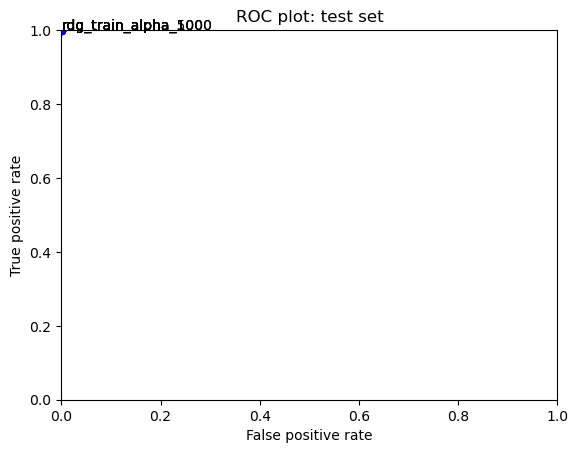

In [84]:
fits = [
        ols_performance_train,
        svm_performance_train,
        lgs_performance_train,
        nbs_performance_train,
        prc_performance_train,
        rdg_performance_train, 
        rdg2_performance_train, 
        rdg3_performance_train, 
        rdg4_performance_train, 
        rdg5_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### MODEL: Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 5486, 'TN': 7360, 'FP': 2648, 'FN': 4506, 'Accuracy': 0.6423, 'Precision': 0.6744529136955987, 'Recall': 0.5490392313851081, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

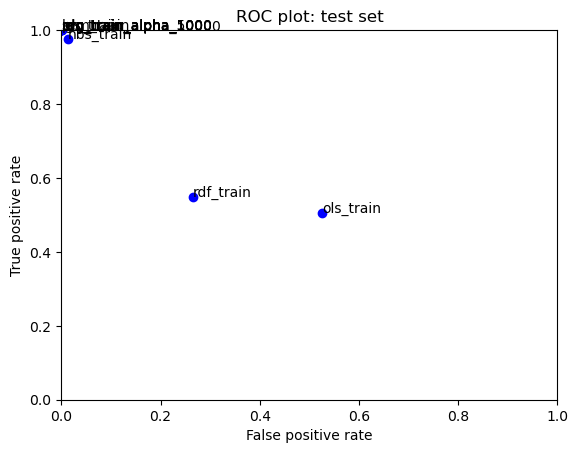

In [18]:
fits = [ols_performance_train, 
        svm_performance_train, 
        lgs_performance_train, 
        nbs_performance_train, 
        prc_performance_train, 
        rdg_performance_train, 
        rdg2_performance_train, 
        rdg3_performance_train, 
        rdg4_performance_train, 
        rdg5_performance_train,
        rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [19]:
print('OLS ROC AUC: ', roc_auc_score(y_train,ols.predict(X_train)))
print('SVM ROC AUC: ', roc_auc_score(y_train,svm.predict(X_train)))
print('LGS ROC AUC: ', roc_auc_score(y_train,lgs.predict(X_train)))
print('NBS ROC AUC: ', roc_auc_score(y_train,nbs.predict(X_train)))
print('PRC ROC AUC: ', roc_auc_score(y_train,prc.predict(X_train)))
print('RDG ROC AUC: ', roc_auc_score(y_train,rdg.predict(X_train)))
print('RDF ROC AUC: ', roc_auc_score(y_train,rdf.predict(X_train)))

OLS ROC AUC:  0.4898127934801878
SVM ROC AUC:  1.0
LGS ROC AUC:  1.0
NBS ROC AUC:  0.9810456278692018
PRC ROC AUC:  1.0
RDG ROC AUC:  1.0
RDF ROC AUC:  0.6422254510242886


### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [20]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [21]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
108
I enjoy a good, slow-moving drama. Christmas In August, Chungking Express, Virgin Stripped Bare By Her Bachelors, The Way Home, Springtime in a Small Town, Hana bi, Eat Drink Man Woman, Dolls, In the Mood for Love, and Spring Summer Fall Winter Spring are all enjoyable films  just to name a few. <br /><br />Unfortunately, there is a subset of films within the drama genre that attempt to ride the coattails of good films while providing nothing of interest themselves. These are what I call IAN films  \Incomprehensible Artistic Nonsense.\" Tsai Ming-liang is the king of this subgenre, and Vive L'Amour is his \"masterpiece.\" In fact, this is the crème de la crème of crap-infested garbage under the guise of \"art.\" People walk around in their apartments, drink water, stroll back and forth waiting for pay phones to become vacant, hang posters, staple papers together, go to the bathroom, eat, do pushups, have sex, slap at mosquitoes, etc. I'm not joking wh

2707
Few movies have dashed expectations and upset me as much as Fire has. The movie is pretentious garbage. It does not achieve anything at an artistic level. The only thing it managed to receive is a ban in India. If only it was because of the poor quality of film making rather than the topical controversy, the ban would have been more justifiable.<br /><br />Now that I've got my distress out of my system, I am more able to analyse the movie: <br /><br />* From the onset the movie feels unreal especially when the protagonists start conversing in English. The director, of course, did not make the movie for an Indian audience; however it underestimated its international audiences by over simplifying it. Watching the character of the domestic help conversing in perfect English is too unreal to be true.<br /><br />* Next we get regular glimpses into Radha's dreams. These scenes are not very effective. They coming up as jarring and obstruct the flow of the movie. I'm still wondering how t

4666
Only a handful of the segments are engaging here. A segment with a garage attendant from Nigeria is heartbreaking. One with Fanny Ardent & Bob Hoskins makes its point, twist by twist until the final shot overplays things. <br /><br />The problem with this movie is that only a few of the clips invoke Paris. The others are so scatter-shot in theme, tone, volition & production that you may as well be watching \The Years Best Commercials, 2006.\" It's really all over the place. It doesn't develop over it's running time, and nothing reigns the directors in. No construct successfully joins the pieces... tedium sets in. I'm at the one hour, twenty minute point and Elijah Wood is in some dumb, over-commercial, overproduced vampire shtick. It has about as much to do with Paris as old ladies knitting in the Antartic. Fantasy shows up I think first in the Coen Brothers segment (Uh, thanks J & E for ruining another movie) and then makes way too many appearances. The point of being in Paris is

6463
A huge disappointment from writer Hamm and director Dante. Their previous collaboration on the first season's \Homecoming\" was twisted and darkly hilarious in all the right ways. This poor handling of an intriguing premise left me bewildered. The supposed \"payoff\" showing generic aliens extracting something from the brains of the infected psychopaths was completely unsatisfying and explained nothing. If the point of the story was an extraterrestrial \"cleaning\" of the planet of it's human infestation, why did they go about it in such a gratuitously sadistic and misogynistic fashion? Why not just unleash a completely lethal virus a la Stephen King's \"The Stand\" instead of having the male population butcher the females? I kept hoping the episode would improve as I kept watching but it just got more pretentious and preposterous. The religious subtext simply seemed forced but it was clear Sam Hamm must have thought it was profound by the weight he gave it. I like a lot of both D

8723
This was thought to be the flagship work of the open source community, something that would stand up and scream at the worlds media to take notice as we're not stuck in the marketing trap with our options in producing fine work with open source tools. After the basic version download ( die hard fan here on a dial-up modem ) eventually got here I hit my first snag. Media Player, Mplayer Classic & winamp failed to open it on my xp box, and then Totem, xine & kaffeine failed to open it on my suse server. Mplayer managed to run it flawlessly. Going to be hard to spread the word about it if normal users cant even open it...<br /><br />The Film. Beautiful soundtrack, superb lighting, masterful camera work and flawless texturing. Everything looked real. And then the two main characters moved.... and spoke... And the movie died for me. Everything apart from the lip syncing and the actual animation of the two main characters ( except for Proog in the dancing scene ) looked fluid and totall

10412
Those 2 points are dedicated the reasonable performance from Akshay Kumar. I know Bollywood films do not really strive to be realistic but PLEASE a Walt Disney production is more realistic than this plot. The father is dying and does what any good parent does...kick his son out the son with his PREGNANT wife. A few things that were too hard to swallow- 1. Priyanka 'cool indoor swimming pool in the bedroom' and to go from that to living hungry in her in-laws garden shed???????? 2. Akshay suddenly got the job as a stunt man, gets bitten by rabified dogs, to then just walk off. This film is an INSulT to our intelligence I really cant believe i contributed financially to the 'people' who made this film by taking my family to see it, we left the cinema with a frown, please do not subject yourself to this mess to watching this take my advice and do not waste your 'waqt'.
* * * * * * * * * 
10416
A really bad sequel. Part 1 had a lot of funny moments - part 2 is just bad (in a boring wa

13706
Billed as a kind of sequel to The Full Monty, about unemployed men in Sheffield, this movie is a fake.<br /><br />As someone born in Sheffield, and still with links to the city, I was extremely disappointed by this film. Someone said it could have been set in Oklahoma, and that just about sums it up for me. This looked like a romantic view of northern England made for the US market. Probably many Americans - and many southern English people - don't realize that Sheffield is a big city of around half a million inhabitants, with a sophisticated urban culture. In Among Giants it was depicted as some dreary dead-end semi-rural small town, where everyone in Sheffield seemed to drink in the same old-fashioned pub, and where the people's idea of a party was line-dancing in some village-hall lookalike. This was a small close-knit community, not a metropolitan city.<br /><br />The working-class Sheffield men were totally unlike their real-life counterparts, who are generally taciturn and 

14634
In the last 10 years I have worked in 3 different indie professional wrestling organizations, managed many pro wrestlers (including 2 Backyard Wrestling stars), worked on 2 different wrestling TV programs and did voice-overs and commentary for many wrestling DVD's. I have NEVER witnessed the level of outright amateurish stupidity, lack of talent and skill, and shoddy production quality found in Splatter Rampage Wrestling. To even list this as a wrestling video of ANY kind is an outright misuse of the term. Shot with low-dollar video cameras, it's essentially home videos of kids play-fighting in back yards. The sound quality is bad, the video quality is bad, and the acting is horrendous. The \wrestlers\" wear makeshift costumes with hand-drawn tee shirts and ski masks and hit each other with a variety of items and halfway imitate wrestling moves. Sometimes the \"matches\" are on the grass. Sometimes on a back yard trampoline. ALL are poorly acted and executed with a shameless lack

18011
This is easily the most disappointing, least gratifying movie of the entire so-called blacksploitation genre, which, by the way, are films we generally enjoy a great deal in our home. Rather than being \exploitation\" or demeaning, these films actually provide a priceless insight into an era. Well, not Bucktown.<br /><br />In this story, Duke returns to Bucktown to operate the night club left to him by his recently deceased brother. He quickly learns that the city is entirely controlled by a corrupt police force, bleeding protection money out of all the local businesses. Duke resists, and determines that he will rescue the city from the corrupt police. Unfortunately, he does so by calling in a posse of his friends (these people are vaguely explained as some former black-militants who have worked with Duke on \"jobs\" in the past) and they simply murder the entire police department in cold blood. And literally in the presence of hundreds of witnesses who do nothing to stop it. Ign

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [22]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 1314, 'TN': 1172, 'FP': 1320, 'FN': 1194, 'Accuracy': 0.4972, 'Precision': 0.4988610478359909, 'Recall': 0.5239234449760766, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [23]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2039, 'TN': 2081, 'FP': 411, 'FN': 469, 'Accuracy': 0.824, 'Precision': 0.8322448979591837, 'Recall': 0.8129984051036683, 'desc': 'svm_test'}


### MODEL: logistic regression

In [24]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2089, 'TN': 2063, 'FP': 429, 'FN': 419, 'Accuracy': 0.8304, 'Precision': 0.829626687847498, 'Recall': 0.8329346092503987, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [25]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 1942, 'TN': 1887, 'FP': 605, 'FN': 566, 'Accuracy': 0.7658, 'Precision': 0.762465645857872, 'Recall': 0.7743221690590112, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [26]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2086, 'TN': 2068, 'FP': 424, 'FN': 422, 'Accuracy': 0.8308, 'Precision': 0.8310756972111554, 'Recall': 0.8317384370015949, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [27]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test_alpha_1')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2117, 'TN': 2030, 'FP': 462, 'FN': 391, 'Accuracy': 0.8294, 'Precision': 0.820860798759209, 'Recall': 0.8440988835725678, 'desc': 'rdg_test_alpha_1'}


In [28]:
rdg2_performance_test = BinaryClassificationPerformance(rdg2.predict(X_test), y_test, 'rdg_test_alpha_100')
rdg2_performance_test.compute_measures()
print(rdg2_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2119, 'TN': 2035, 'FP': 457, 'FN': 389, 'Accuracy': 0.8308, 'Precision': 0.8225931677018633, 'Recall': 0.844896331738437, 'desc': 'rdg_test_alpha_100'}


In [29]:
rdg3_performance_test = BinaryClassificationPerformance(rdg3.predict(X_test), y_test, 'rdg_test_alpha_1000')
rdg3_performance_test.compute_measures()
print(rdg3_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2140, 'TN': 2072, 'FP': 420, 'FN': 368, 'Accuracy': 0.8424, 'Precision': 0.8359375, 'Recall': 0.8532695374800638, 'desc': 'rdg_test_alpha_1000'}


In [30]:
rdg4_performance_test = BinaryClassificationPerformance(rdg4.predict(X_test), y_test, 'rdg_test_alpha_5000')
rdg4_performance_test.compute_measures()
print(rdg4_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2193, 'TN': 2123, 'FP': 369, 'FN': 315, 'Accuracy': 0.8632, 'Precision': 0.8559718969555035, 'Recall': 0.8744019138755981, 'desc': 'rdg_test_alpha_5000'}


In [31]:
rdg5_performance_test = BinaryClassificationPerformance(rdg5.predict(X_test), y_test, 'rdg_test_alpha_10000')
rdg5_performance_test.compute_measures()
print(rdg5_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2218, 'TN': 2150, 'FP': 342, 'FN': 290, 'Accuracy': 0.8736, 'Precision': 0.86640625, 'Recall': 0.8843700159489634, 'desc': 'rdg_test_alpha_10000'}


### MODEL: Random Forest Classifier

In [32]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 1313, 'TN': 1766, 'FP': 726, 'FN': 1195, 'Accuracy': 0.6158, 'Precision': 0.6439431093673369, 'Recall': 0.523524720893142, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

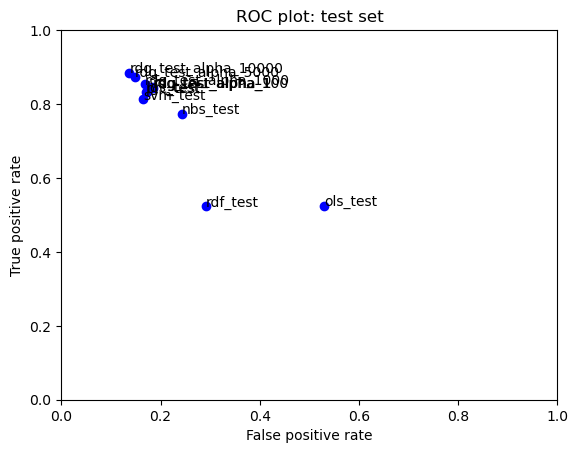

In [35]:
fits = [ols_performance_test, 
        svm_performance_test, 
        lgs_performance_test, 
        nbs_performance_test, 
        prc_performance_test, 
        rdg_performance_test,
        rdg2_performance_test,
        rdg3_performance_test,
        rdg4_performance_test,
        rdg5_performance_test,
        rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [36]:
print('OLS ROC AUC: ', roc_auc_score(y_test,ols.predict(X_test)))
print('SVM ROC AUC: ', roc_auc_score(y_test,svm.predict(X_test)))
print('LGS ROC AUC: ', roc_auc_score(y_test,lgs.predict(X_test)))
print('NBS ROC AUC: ', roc_auc_score(y_test,nbs.predict(X_test)))
print('PRC ROC AUC: ', roc_auc_score(y_test,prc.predict(X_test)))
print('RDG ROC AUC: ', roc_auc_score(y_test,rdg.predict(X_test)))
print('RDG2 ROC AUC: ', roc_auc_score(y_test,rdg2.predict(X_test)))
print('RDG3 ROC AUC: ', roc_auc_score(y_test,rdg3.predict(X_test)))
print('RDG4 ROC AUC: ', roc_auc_score(y_test,rdg4.predict(X_test)))
print('RDG5 ROC AUC: ', roc_auc_score(y_test,rdg5.predict(X_test)))
print('RDF ROC AUC: ', roc_auc_score(y_test,rdf.predict(X_test)))

OLS ROC AUC:  0.4971142104495151
SVM ROC AUC:  0.8240353181216575
LGS ROC AUC:  0.8303918632126794
NBS ROC AUC:  0.7657726415118491
PRC ROC AUC:  0.8307969873611506
RDG ROC AUC:  0.8293528125728007
RDG2 ROC AUC:  0.8307547469286086
RDG3 ROC AUC:  0.8423651058186836
RDG4 ROC AUC:  0.8631640387997572
RDG5 ROC AUC:  0.8735654253099552
RDF ROC AUC:  0.6160962288253832


---

# <span style="color:red">SUBMISSION</span>

---

In [37]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/moviereviews_test.tsv', my_random_seed=24, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 33554432)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Si

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

### Submission 1: I'll be choosing the Ridge Regression model fit with an alpha=10,000.

In [38]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg5.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48292


In [39]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [40]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [41]:
my_submission.shape

(25000, 2)

In [42]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/stephaniedang/Documents/Documents/MSDV_Spring_2023/Machine_Learning/assignment1/moviereviews_submission2.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation